#Customer Churn Prediction Analysis

##Introduction
Consider an e-commerce company with historical data on how its clients have interacted with its services. The company wants to know the likelihood of customers churning so it can launch targeted marketing campaigns.


#Data Preprocessing and preparation

##Loading the necessary libraries

In [76]:
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTE
import os
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
import joblib

import warnings
warnings.filterwarnings('ignore')

In [77]:
#To make the code reproducible
np.random.seed(42)

###Loading the Dataset

In [78]:
path = kagglehub.dataset_download("ankitverma2010/ecommerce-customer-churn-analysis-and-prediction")

# Get the list of files in the downloaded directory
files = os.listdir(path)

# Find the Excel file (assuming it has .xlsx or .xls extension)
excel_file = [f for f in files if f.endswith(('.xlsx', '.xls'))][0]

# Construct the full path to the Excel file
file_path = os.path.join(path, excel_file)

# Now read the Excel file using the correct path
df = pd.read_excel(file_path, sheet_name="E Comm")


###Explore the dataset

In [79]:
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [80]:
df.shape

(5630, 20)

In [28]:
df.describe().info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, count to max
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   8 non-null      float64
 1   Churn                        8 non-null      float64
 2   Tenure                       8 non-null      float64
 3   CityTier                     8 non-null      float64
 4   WarehouseToHome              8 non-null      float64
 5   HourSpendOnApp               8 non-null      float64
 6   NumberOfDeviceRegistered     8 non-null      float64
 7   SatisfactionScore            8 non-null      float64
 8   NumberOfAddress              8 non-null      float64
 9   Complain                     8 non-null      float64
 10  OrderAmountHikeFromlastYear  8 non-null      float64
 11  CouponUsed                   8 non-null      float64
 12  OrderCount                   8 non-null      float64
 13  DaySinceLastOrder      

In [81]:
# Summary statistics
df.describe()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,52815.500000,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.223030
std,1625.385339,0.374240,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.207036
min,50001.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,52815.500000,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.280000
75%,54222.750000,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.392500
max,55630.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,324.990000


In [82]:
# Check dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

###Handle Missing values

In [83]:
# Count missing values per column
missing_values = df.isnull().sum()
print(missing_values)


CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64


In [84]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [85]:
df.nunique()

,0
CustomerID,5630
Churn,2
Tenure,36
PreferredLoginDevice,3
CityTier,3
WarehouseToHome,34
PreferredPaymentMode,7
Gender,2
HourSpendOnApp,6
NumberOfDeviceRegistered,6


In [86]:
df.drop(columns="CustomerID", inplace=True)

In [87]:
#check column names
df.columns

Index(['Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [88]:
# Change column names to lowercase
df.columns = [col.lower() for col in df.columns]
df.columns

Index(['churn', 'tenure', 'preferredlogindevice', 'citytier',
       'warehousetohome', 'preferredpaymentmode', 'gender', 'hourspendonapp',
       'numberofdeviceregistered', 'preferedordercat', 'satisfactionscore',
       'maritalstatus', 'numberofaddress', 'complain',
       'orderamounthikefromlastyear', 'couponused', 'ordercount',
       'daysincelastorder', 'cashbackamount'],
      dtype='object')

The dataset is read into a Pandas DataFrame, and an initial exploration is performed using head(), info(), and describe() functions to inspect the structure and statistical summary.

Output Explanation: Displays the first few rows, column data types, and summary statistics, helping us understand the dataset's composition and potential issues like missing values.

###Exploratory Data Analysis

In [89]:
# segment the columns of the DataFrame into two lists based on the number of unique values each column contains.
count_col = []
hist_col = []
for column in df.columns:
    unique_value = df[column].nunique()
    if unique_value <= 20:
        count_col.append(column)
    else:
        hist_col.append(column)

Countplots of Categorical columns

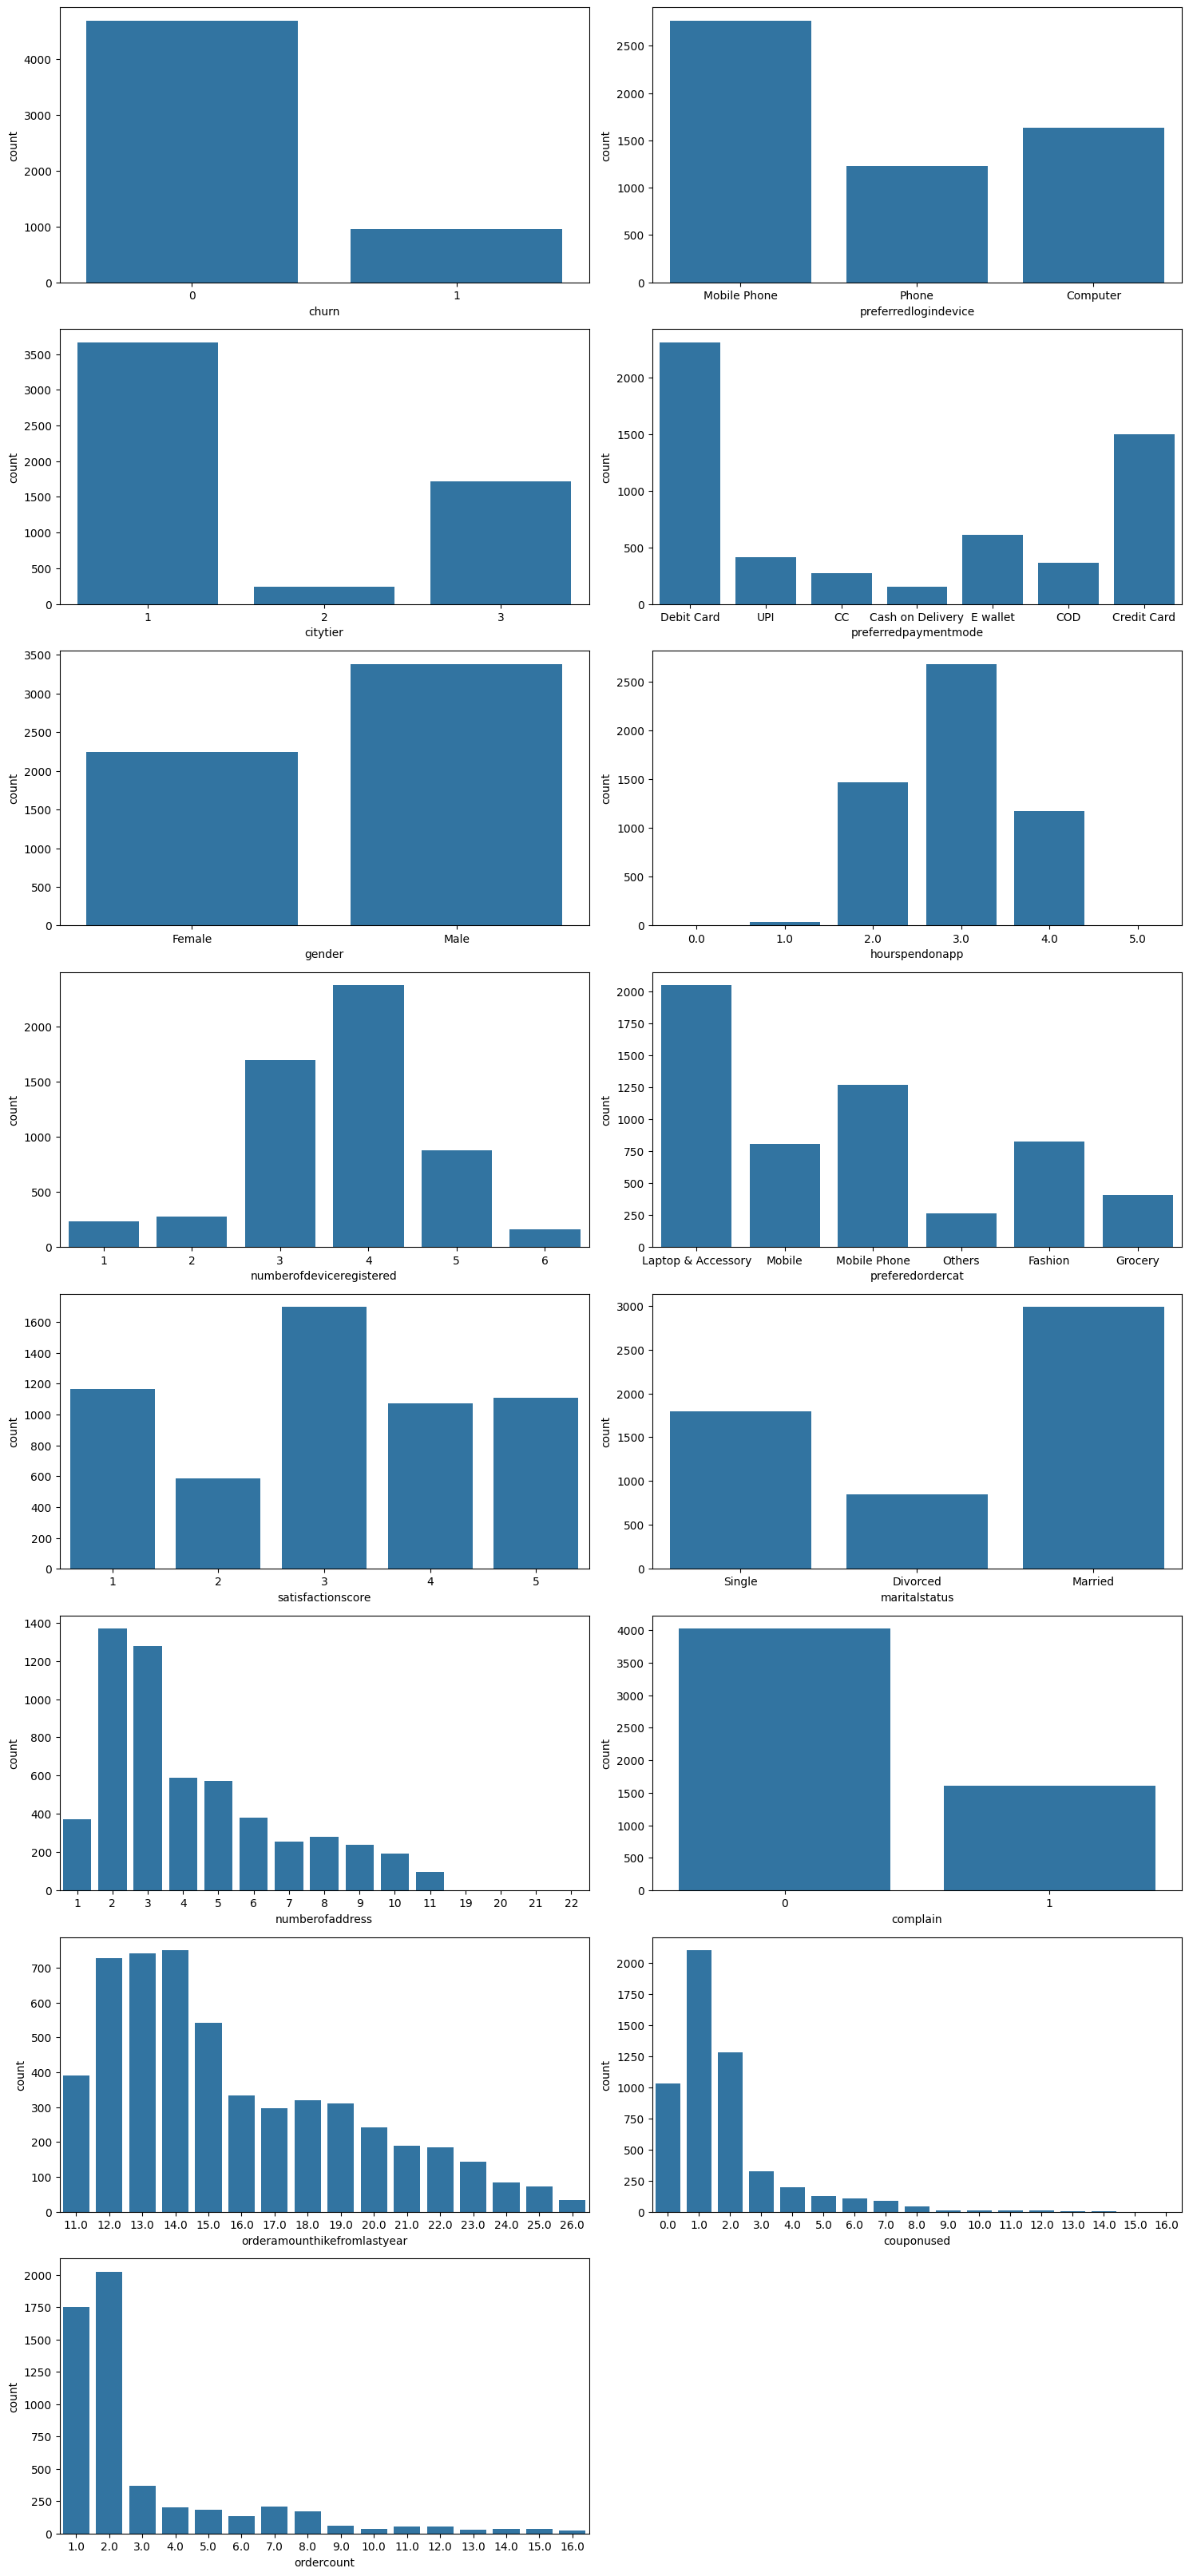

In [90]:
plt.figure(figsize=(15,40))
plot_num = 1
for col in count_col:
    plt.subplot(10,2,plot_num)
    sns.countplot(data=df, x=col)
    plot_num += 1
    plt.tight_layout()

Histograms of numerical columns

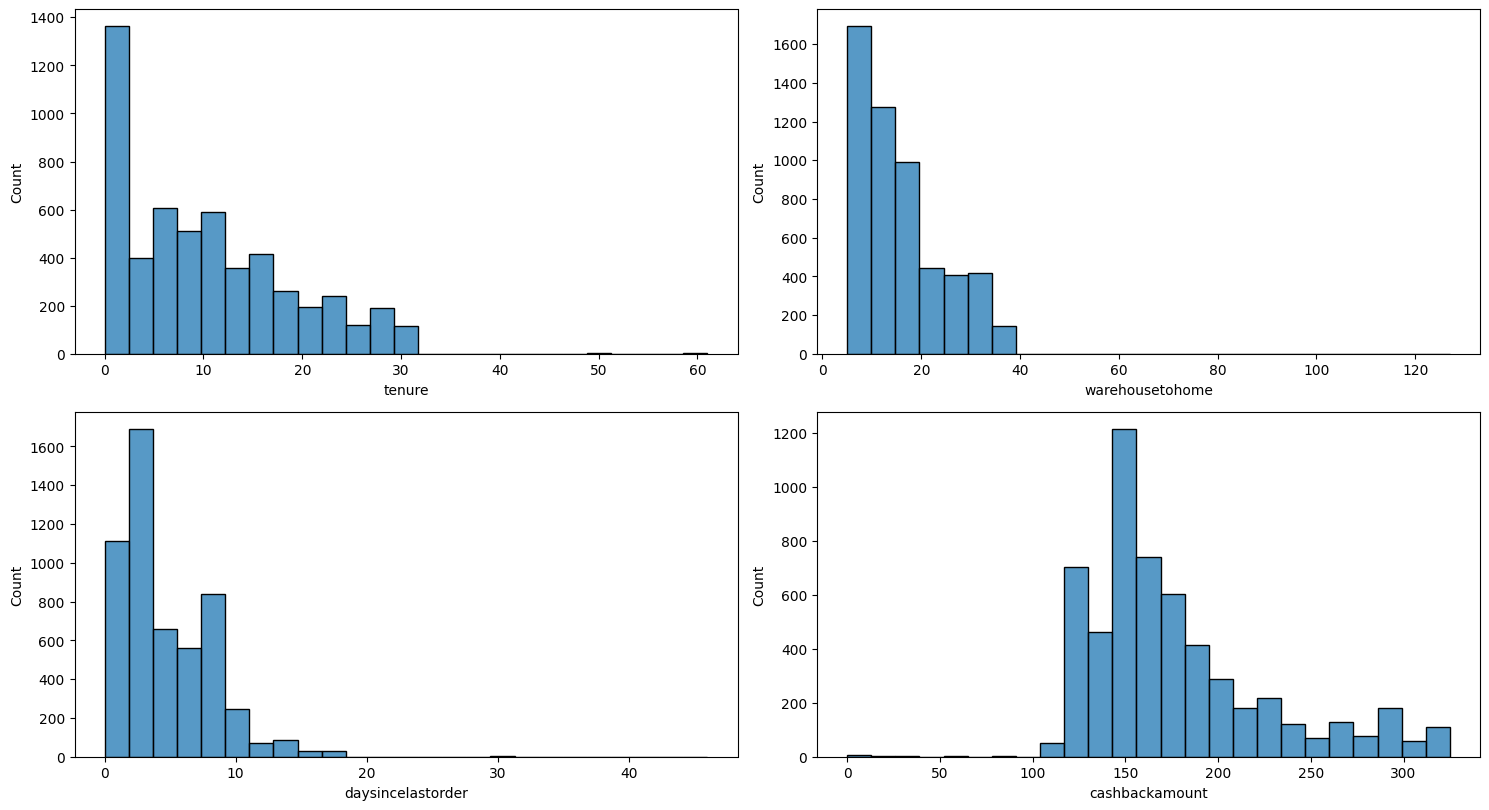

In [91]:
plt.figure(figsize=(15,40))
plot_num = 1
for col in hist_col:
    plt.subplot(10,2,plot_num)
    sns.histplot(data=df, x=col,bins=25)
    plot_num += 1
    plt.tight_layout()

Plot the Churn distribution for each categorical variable

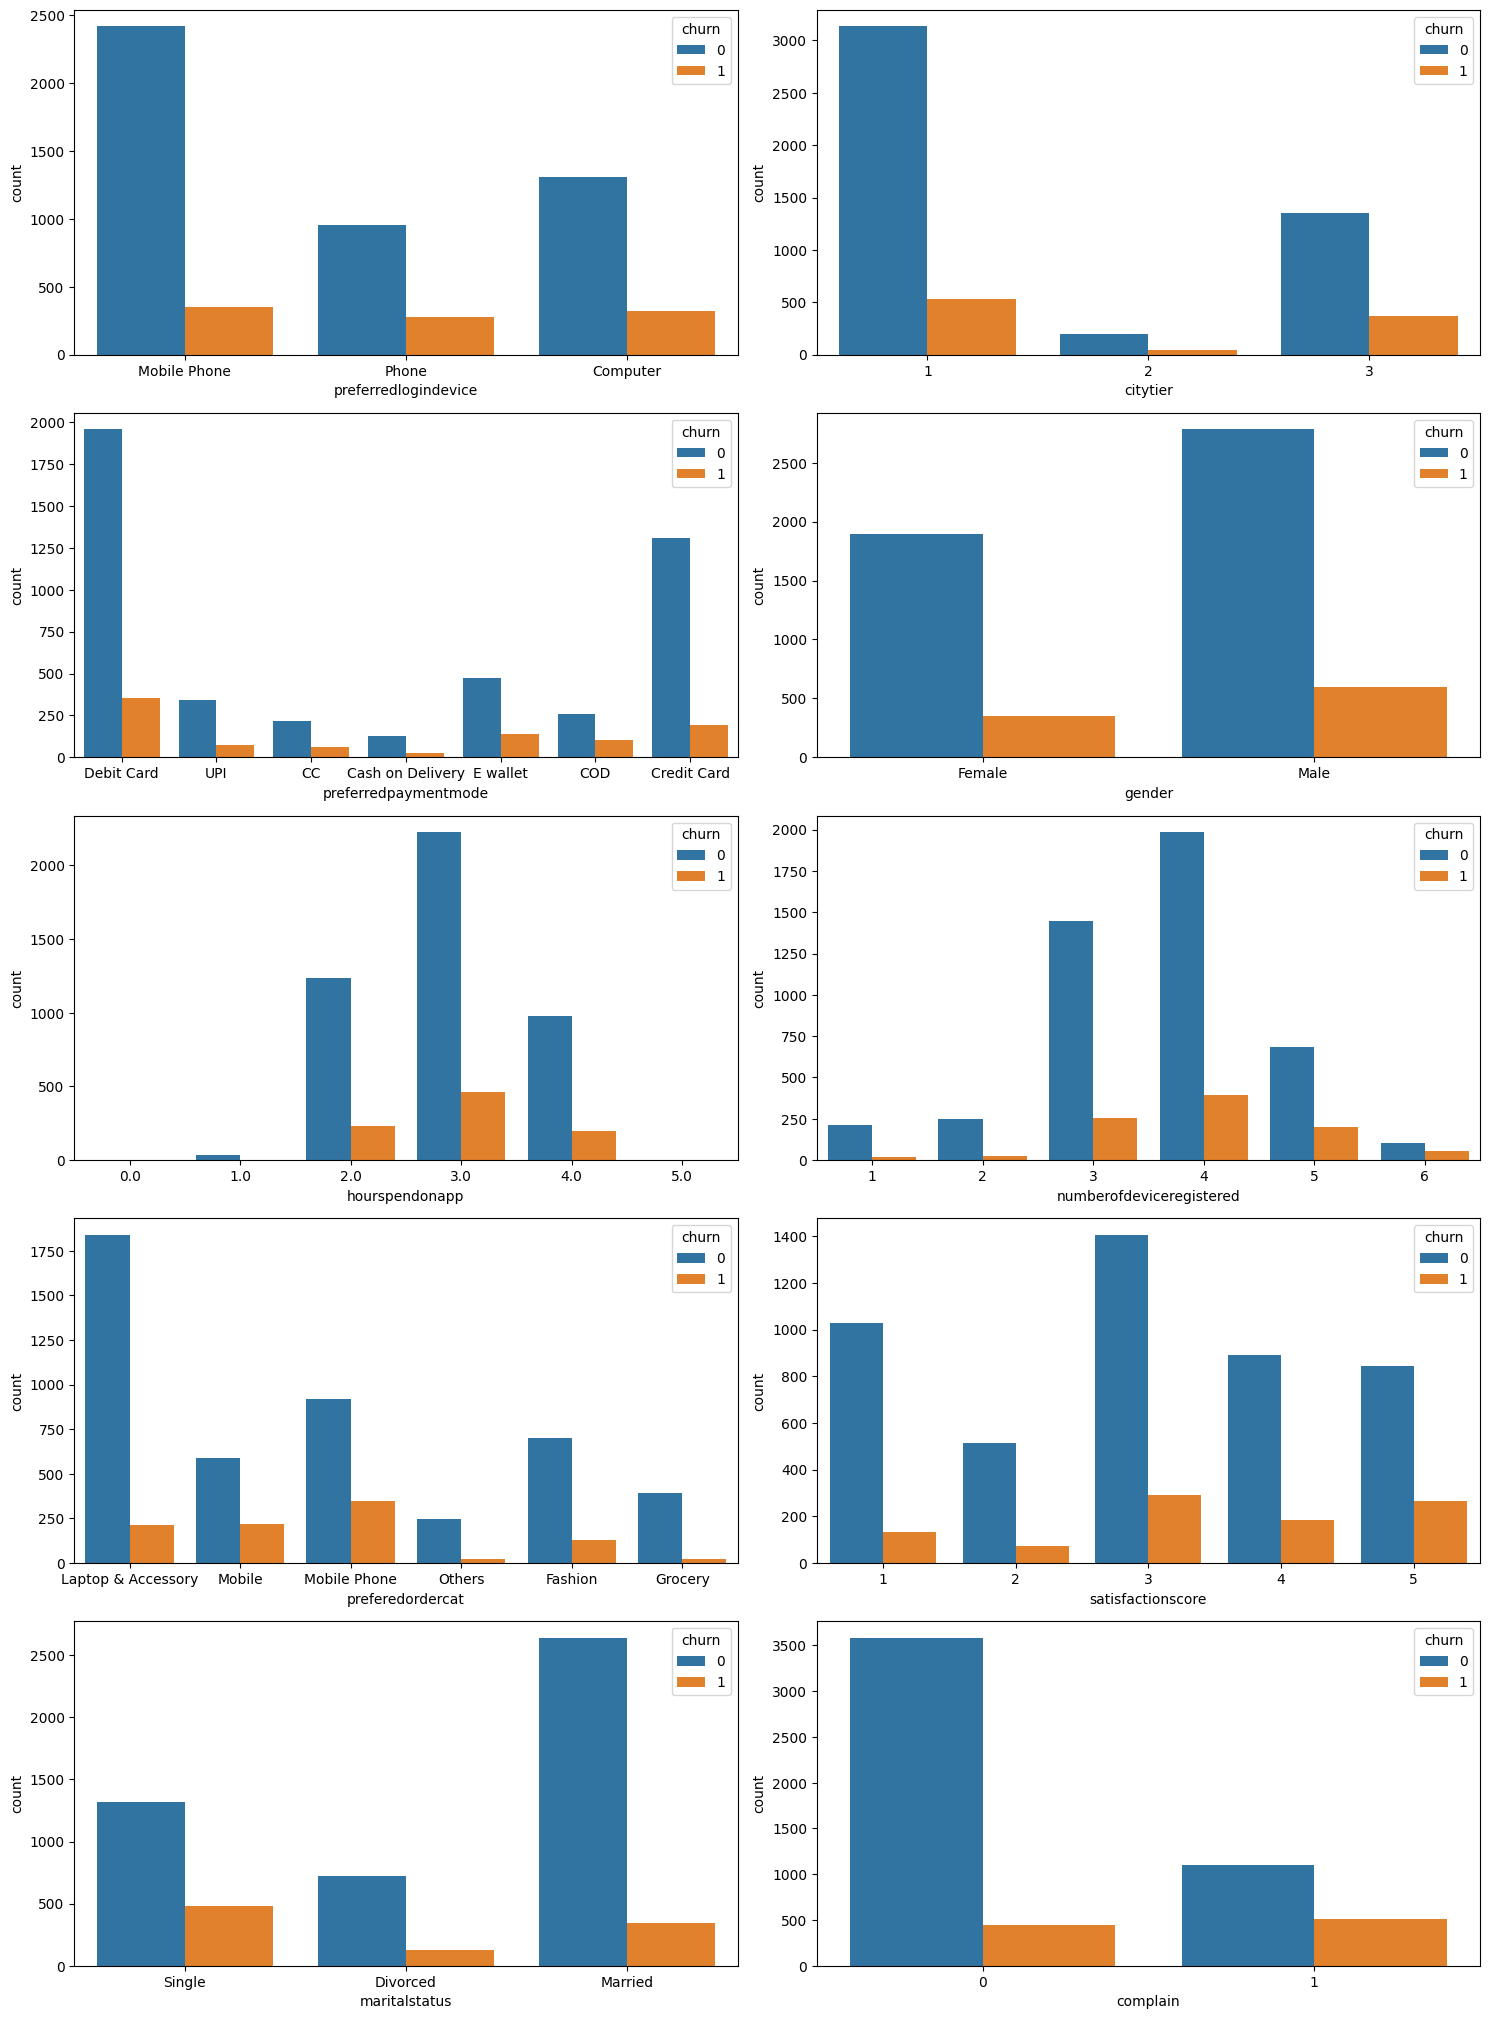

In [92]:
plt.figure(figsize=(15,40))
plot_num = 1
for col in count_col:
    if df[col].nunique() <= 8 and col != "churn":
        plt.subplot(10,2,plot_num)
        sns.countplot(data=df, x=col, hue="churn")
        plot_num += 1
        plt.tight_layout()

###Impute missing values

In [93]:
#Handle missing values
def fill_missing_values(df, random_state=None):
    # Step 1: Identify numeric and categorical columns
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()  # Include both string and category data

    # Step 2: Impute numeric columns
    numeric_imputer = SimpleImputer(strategy='mean')
    df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

    # Step 3: Handle categorical columns
    for col in categorical_columns:
        if df[col].dtype == 'object':
            # Convert categorical column to one-hot encoded representation
            encoded_cols = pd.get_dummies(df[col], prefix=col)
            # Concatenate one-hot encoded columns
            df = pd.concat([df.drop(col, axis=1), encoded_cols], axis=1)

    # Step 4: Random Forest Iterative Imputer for the entire DataFrame
    rf_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=random_state))
    df = pd.DataFrame(rf_imputer.fit_transform(df), columns=df.columns)

    return df

# Call the function to fill missing values
df = fill_missing_values(df, random_state=42)

Missing values are detected and handled using a numerical imputer, which replaces missing values with the median or mean to maintain consistency.

Output Explanation: Prints the count of missing values before and after handling, ensuring no null values remain.


Categorical variables are converted into numerical format using one-hot encoding or label encoding.

Output Explanation: Shows the transformed dataset where categorical columns are replaced with numeric representations, making them usable for machine learning models.

Numerical features are normalized using MinMaxScaler or StandardScaler to ensure they have comparable ranges.

Output Explanation: Displays the scaled values, confirming that the features have been standardized properly.

Numerical features are normalized using MinMaxScaler or StandardScaler to ensure they have comparable ranges.

Output Explanation: Displays the scaled values, confirming that the features have been standardized properly.

In [95]:
df.head()

,churn,tenure,citytier,warehousetohome,hourspendonapp,numberofdeviceregistered,satisfactionscore,numberofaddress,complain,orderamounthikefromlastyear,couponused,ordercount,daysincelastorder,cashbackamount,preferredlogindevice_Computer,preferredlogindevice_Mobile Phone,preferredlogindevice_Phone,preferredpaymentmode_CC,preferredpaymentmode_COD,preferredpaymentmode_Cash on Delivery,preferredpaymentmode_Credit Card,preferredpaymentmode_Debit Card,preferredpaymentmode_E wallet,preferredpaymentmode_UPI,gender_Female,gender_Male,preferedordercat_Fashion,preferedordercat_Grocery,preferedordercat_Laptop & Accessory,preferedordercat_Mobile,preferedordercat_Mobile Phone,preferedordercat_Others,maritalstatus_Divorced,maritalstatus_Married,maritalstatus_Single
0,1.0,4.000000,3.0,6.0,3.000000,3.0,2.0,9.0,1.0,11.0,1.0,1.0,5.0,159.93,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,10.189899,1.0,8.0,3.000000,4.0,3.0,7.0,1.0,15.0,0.0,1.0,0.0,120.90,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,10.189899,1.0,30.0,2.000000,4.0,3.0,6.0,1.0,14.0,0.0,1.0,3.0,120.28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.000000,3.0,15.0,2.000000,4.0,5.0,8.0,0.0,23.0,0.0,1.0,3.0,134.07,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.000000,1.0,12.0,2.931535,3.0,5.0,3.0,0.0,11.0,1.0,1.0,3.0,129.60,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


##Model Building

###Define Target Variable

In [96]:
X = df.drop(columns=["churn"])
y = df["churn"]

###Split dataset into train and test sets

In [97]:
# Split model into training and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The dataset is split into training and testing sets using train_test_split() to ensure the model generalizes well.

Output Explanation: Prints the number of samples in each subset, ensuring an appropriate split ratio.

###Handling the Imbalanced dataset

In [98]:
print('Before upsampling count of label 0 {}'.format(sum(y_train==0)))
print('Before upsampling count of label 1 {}'.format(sum(y_train==1)))
# Minority Over Sampling Technique
sm = SMOTE(sampling_strategy = 1, random_state=1)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train.ravel())

print('After upsampling count of label 0 {}'.format(sum(y_train_s==0)))
print('After upsampling count of label 1 {}'.format(sum(y_train_s==1)))

Before upsampling count of label 0 3741
Before upsampling count of label 1 763
After upsampling count of label 0 3741
After upsampling count of label 1 3741


The dataset is balanced using SMOTE, which synthesizes new minority class examples to prevent model bias.

Output Explanation: Displays class distribution before and after SMOTE application, showing improved balance.

In [99]:
# Initialize models
models = [
    # Neural Network
    ('MLP', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)),

    # Gradient Boosting
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),

    # Linear Models
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Ridge Classifier', RidgeClassifier(random_state=42)),

    # SVM
    ('SVM', SVC(probability=True, random_state=42)),

    # Random Forest
    ('Random Forest', RandomForestClassifier(random_state=42))
]



Evaluating MLP...
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       941
         1.0       0.77      0.87      0.82       185

    accuracy                           0.94      1126
   macro avg       0.87      0.91      0.89      1126
weighted avg       0.94      0.94      0.94      1126



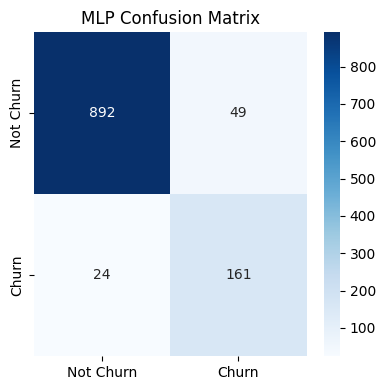


Evaluating Gradient Boosting...
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       941
         1.0       0.79      0.73      0.76       185

    accuracy                           0.92      1126
   macro avg       0.87      0.85      0.86      1126
weighted avg       0.92      0.92      0.92      1126



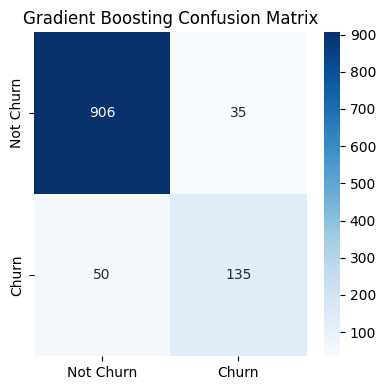


Evaluating Logistic Regression...
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89       941
         1.0       0.50      0.83      0.62       185

    accuracy                           0.83      1126
   macro avg       0.73      0.83      0.76      1126
weighted avg       0.88      0.83      0.85      1126



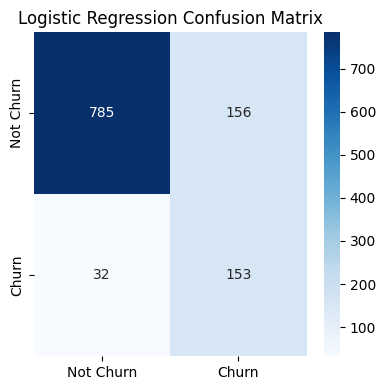


Evaluating Ridge Classifier...
              precision    recall  f1-score   support

         0.0       0.96      0.82      0.88       941
         1.0       0.47      0.84      0.61       185

    accuracy                           0.82      1126
   macro avg       0.72      0.83      0.75      1126
weighted avg       0.88      0.82      0.84      1126



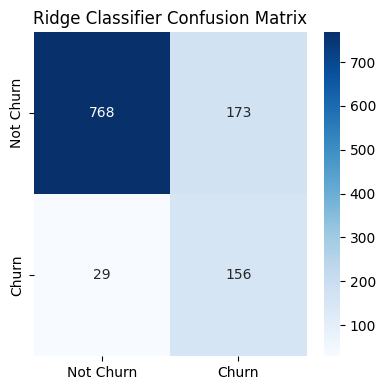


Evaluating SVM...
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82       941
         1.0       0.36      0.79      0.49       185

    accuracy                           0.73      1126
   macro avg       0.65      0.76      0.65      1126
weighted avg       0.85      0.73      0.76      1126



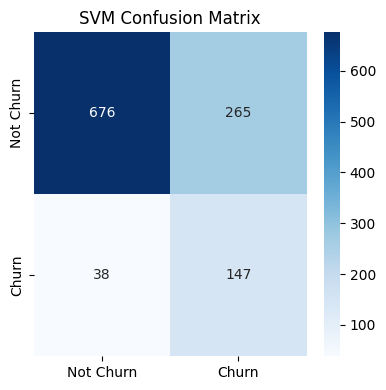


Evaluating Random Forest...
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       941
         1.0       0.98      0.85      0.91       185

    accuracy                           0.97      1126
   macro avg       0.98      0.93      0.95      1126
weighted avg       0.97      0.97      0.97      1126



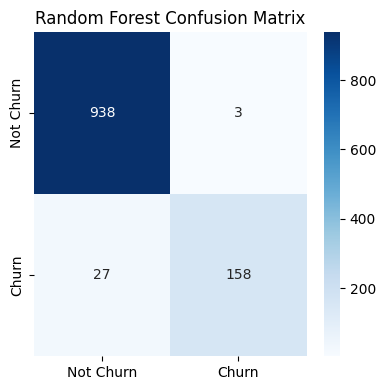


=== Model Performance Comparison ===


,Accuracy,Precision,Recall,F1,ROC AUC
Model,,,,,
MLP,93.52%,76.67%,87.03%,81.52%,0.962
Gradient Boosting,92.45%,79.41%,72.97%,76.06%,0.929
Logistic Regression,83.30%,49.51%,82.70%,61.94%,0.894
Ridge Classifier,82.06%,47.42%,84.32%,60.70%,0.895
SVM,73.09%,35.68%,79.46%,49.25%,0.838
Random Forest,97.34%,98.14%,85.41%,91.33%,0.988


In [110]:
# Prepare results table
results = []
for name, model in models:  # Corrected line: Removed .items()
    print(f"\nEvaluating {name}...")

    # Train model
    model.fit(X_train_s, y_train_s)  # Corrected line: Use X_train_s and y_train_s

    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Calculate metrics
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob)
    })

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churn', 'Churn'],
                yticklabels=['Not Churn', 'Churn'])
    plt.title(f'{name} Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Display comprehensive results
results_df = pd.DataFrame(results).set_index('Model')
print("\n=== Model Performance Comparison ===")
display(results_df.style.format({
    'Accuracy': '{:.2%}',
    'Precision': '{:.2%}',
    'Recall': '{:.2%}',
    'F1': '{:.2%}',
    'ROC AUC': '{:.3f}'
}).background_gradient(cmap='Blues', subset=['Accuracy', 'F1', 'ROC AUC']))

### FINAL MODEL SELECTION & SAVING

In [112]:
# Select best model based on ROC AUC
best_model_name = results_df['ROC AUC'].idxmax()

# Find the model object corresponding to the best model name
best_model = next((model for name, model in models if name == best_model_name), None)

print(f"\nBest model: {best_model_name} (ROC AUC: {results_df.loc[best_model_name, 'ROC AUC']:.3f})")


Best model: Random Forest (ROC AUC: 0.988)


In [113]:
# Save best model and metadata
joblib.dump(best_model, 'best_churn_model.pkl')
joblib.dump({'features': list(X.columns), 'target': 'Churn'}, 'model_metadata.pkl')


['model_metadata.pkl']

###Feature Importance

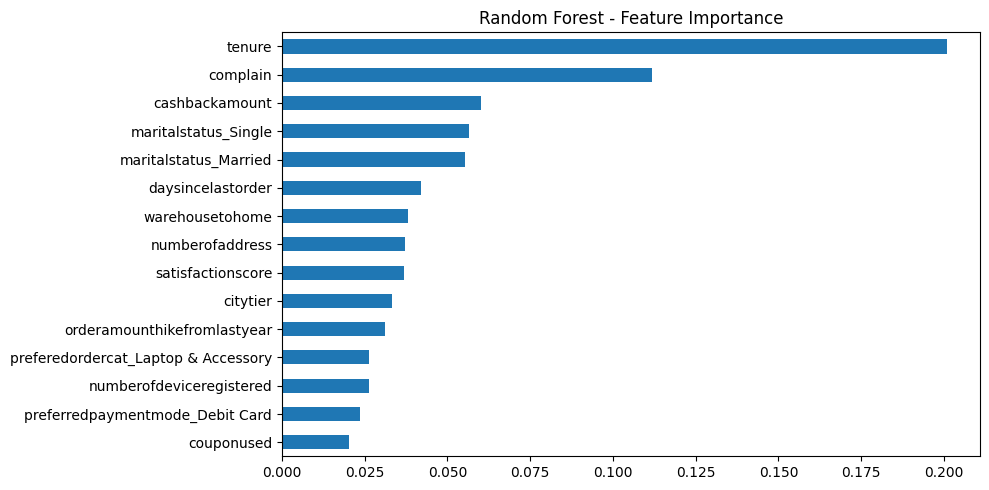

In [114]:
# Feature importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(10,5))
    pd.Series(best_model.feature_importances_, index=X.columns)\
      .nlargest(15).sort_values()\
      .plot(kind='barh', title=f'{best_model_name} - Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()